In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem

import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/'

In [4]:
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220824_142240.h5')
f = h5py.File(closed_loop_h5_file, 'r')

In [50]:
f.keys()

<KeysViewHDF5 ['Client', 'Flies', 'Notes']>

In [65]:
f['Flies']['fly_0']['epoch_runs']['series_001']['stimulus_timing']

<HDF5 group "/Flies/fly_0/epoch_runs/series_001/stimulus_timing" (0 members)>

In [5]:
## Not necessary for continuous 30-min stimulus
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220824_142240.h5')
f = h5py.File(closed_loop_h5_file, 'r')
start_thetas = f.attrs['start_theta']

In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 2000

behavior_traces = {}
mean_trace = {}
sem_trace = {}
#for angle in [0,180]:
for behavior in ['Z', 'h', 'Y']:
    behavior_traces_,mean_trace,sem_trace = extract_traces(fictrac,
                                                          stimulus_start_times,
                                                          pre_window,
                                                          post_window,
                                                          behavior)
    behavior_traces[behavior] = behavior_traces_

loading photodiode data... done


/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/_methods.py:224: RuntimeWarning:

invalid value encountered in true_divide



In [4]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [5]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [6]:
mean_neural = np.mean(neural,axis=(0,1,2))

In [7]:
# shifted_beh = np.roll(fictrac['Y'][:,0],-8)
# scipy.stats.pearsonr(mean_neural, shifted_beh)[0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [7]:
out = scipy.signal.correlate(mean_neural, np.roll(fictrac['Y'][:,0],8))
plt.plot(out)
plt.axvline(3384,color='k')
plt.xlim(2000,4000)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

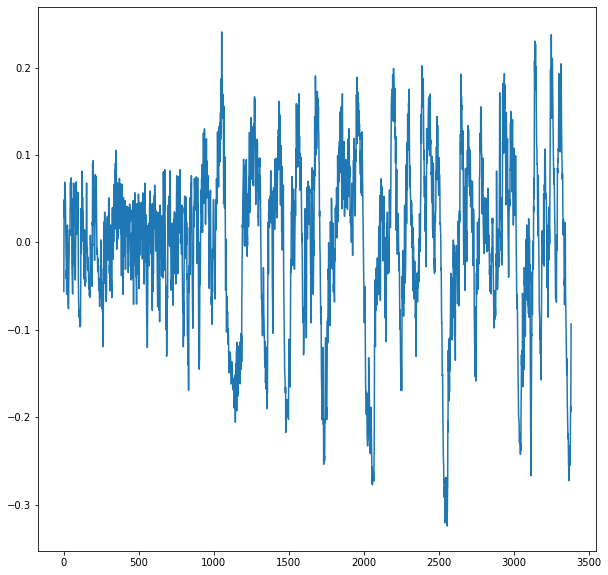

In [8]:
plt.figure(figsize=(10,10))
plt.plot(mean_neural)
shifted_beh = np.roll(fictrac['Y'][:,0],8)
plt.plot(shifted_beh/100)
plt.xlim(1500,2500)

In [9]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [10]:
fixed = brainsss.load_fda_meanbrain()

In [11]:
atlas = brainsss.load_roi_atlas()

In [12]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [14]:
timestamps.shape

(3384, 49)

In [13]:
### GET 3384 RESOLUTION BEHAVIOR ###

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

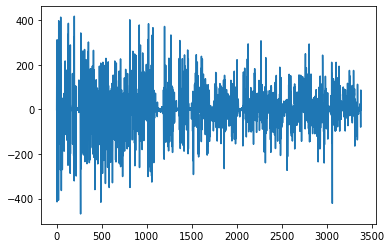

In [14]:
plt.plot(fictrac['Z'].flatten())

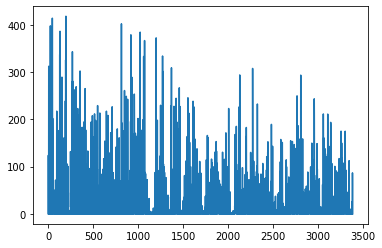

In [15]:
plt.plot(np.clip(fictrac['Z'].flatten(),0,None))

In [16]:
all_signals.shape

(49, 2000, 3384)

In [17]:
timestamps.shape

(3384, 49)

In [18]:
timestamps[:10,0]

array([ 104.654892,  636.650593, 1168.646294, 1700.641995, 2232.637696,
       2764.633397, 3296.629098, 3828.624799, 4360.6205  , 4892.616201])

In [46]:
636.650593-104.654892

531.9957009999999

In [47]:
1000/531.9957009999999

1.8797144377676092

In [19]:
corrs = []
behavior = 'heading'
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    # fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1 #only needed for Z that has +-.
    # shifted_beh = np.roll(fictrac['Y'][:,0],8) # mismatch of the time
    for voxel in range(2000):
        corrs.append(scipy.stats.pearsonr(all_signals[z,voxel,:], fictrac_trace.flatten())[0])

In [20]:
all_signals[z,voxel,:]

array([ 0.20186166, -0.14401965,  0.4253103 , ...,  0.3006766 ,
        0.2586915 ,  1.0763263 ], dtype=float32)

In [21]:
fictrac_trace

array([[6.28161567],
       [5.20907892],
       [5.9667145 ],
       ...,
       [4.58642361],
       [4.59627988],
       [0.        ]])

In [22]:
whole_corr = np.reshape(np.asarray(corrs),(49,2000))

In [23]:
whole_corr.shape

(49, 2000)

In [24]:
def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

In [25]:
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)

In [26]:
whole_corr_reformed.shape

(49, 256, 128)

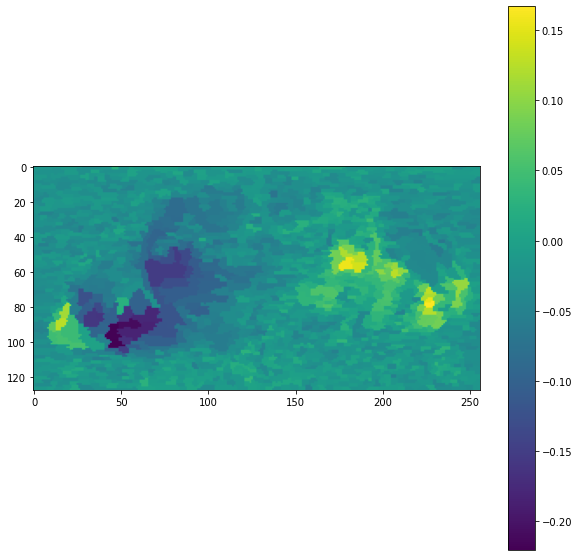

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(whole_corr_reformed[20,:,:].T)
plt.colorbar()

In [28]:
###################
### corr with Y ###
###################

# shifted_beh_z = np.roll(fictrac['Y'][:,0],8)

behavior = 'dRotLabY'
corrs_y = []
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    for x in range(256):
        for y in range(128):
            corrs_y.append(scipy.stats.pearsonr(neural[x,y,z,:], fictrac_trace.flatten())[0])

In [29]:
###################
### corr with Z left turn ###
###################

# shifted_beh_z = np.clip(np.roll(fictrac['Z'][:,0],8),None,0)*-1
behavior = 'dRotLabZ'
corrs_z_l = []
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1
    for x in range(256):
        for y in range(128):
            corrs_z_l.append(scipy.stats.pearsonr(neural[x,y,z,:], fictrac_trace_L.flatten())[0])

In [30]:
###############################
### corr with Z right turn ###
##############################

# shifted_beh_z = np.clip(np.roll(fictrac['Z'][:,0],8),None,0)*-1
behavior = 'dRotLabZ'
corrs_z_r = []
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    fictrac_trace_R = np.clip(fictrac_trace.flatten(),0,None)
    for x in range(256):
        for y in range(128):
            corrs_z_r.append(scipy.stats.pearsonr(neural[x,y,z,:], fictrac_trace_R.flatten())[0])

In [31]:
whole_corr_ZPOS = np.reshape(np.asarray(corrs_y),(49,256,128))

In [32]:
whole_corr = np.reshape(np.asarray(corrs_y),(49,256,128))

In [33]:
whole_corr.shape

(49, 256, 128)

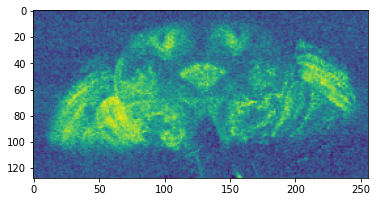

In [34]:
plt.imshow(whole_corr[20,:,:].T)

In [100]:
maxi_projection = np.max(whole_corr, axis = 0)

In [101]:
whole_corr.shape

(49, 256, 128)

In [102]:
whole_corr_reformed.shape

(49, 256, 128)

In [105]:
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
STA_brain.shape

(49, 1, 256, 128)

In [104]:
STA_brain = np.rollaxis(whole_corr_ZPOS[np.newaxis,:,:,:],-1,0)
STA_brain.shape

(128, 1, 49, 256)

In [37]:
#(49, 1, 256, 128) this is correct

In [107]:
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_231', fixed=fixed, anat_to_mean_type='myr')

In [108]:
fixed.shape

(314, 146, 91)

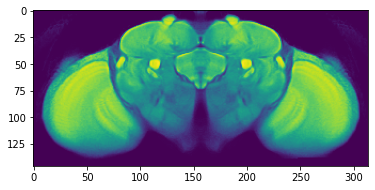

In [109]:
plt.imshow(fixed[:,:,40].T)

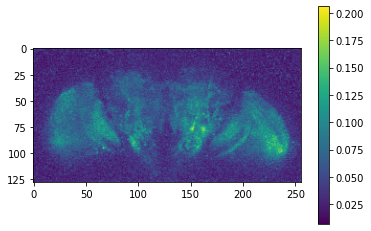

In [110]:
plt.imshow(maxi_projection.T)
plt.colorbar()

In [111]:
plt.imshow(np.max(warps[0],axis=-1).T)

NameError: name 'warps' is not defined

In [118]:
input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warps_ZPOS[0][:,:,::-1]
vmax = .2
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='hot',
                                                            diverging=False)#'hot')

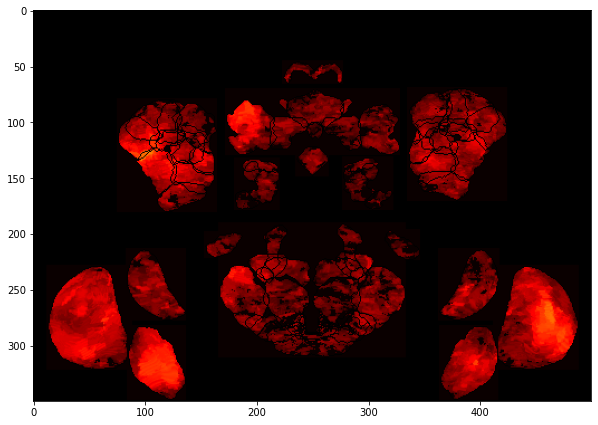

In [119]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

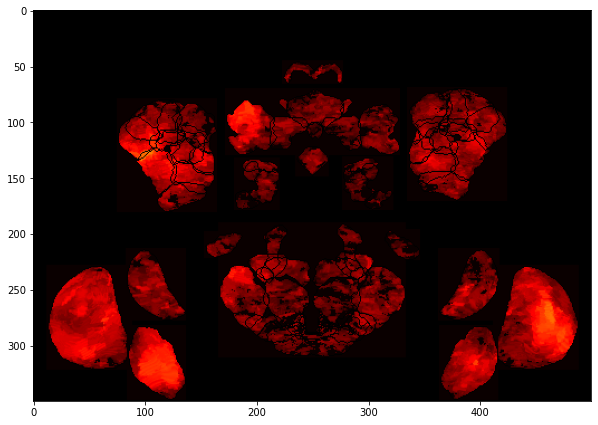

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

# STA

In [45]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*1000).astype('int') #index needs to be an integers

loading photodiode data... done


In [ ]:
len(stimulus_start_times), len(start_thetas)

In [162]:
thetas = np.unique(start_thetas)
theta_categories = {}

for theta in thetas:
    idx = np.where(start_thetas==theta)[0]
    theta_categories[theta] = stimulus_start_times[idx]

In [287]:
cmap[0]

TypeError: 'LinearSegmentedColormap' object does not support indexing

In [294]:
thetas

array([-50, -25,   0,  25,  50])

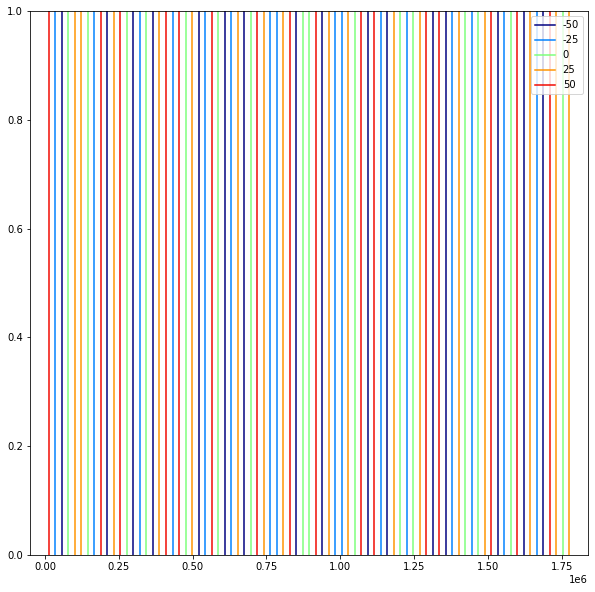

In [296]:
cmap = matplotlib.cm.get_cmap('jet')
plt.figure(figsize=(10,10))
colors = [0,.25,.5,.75,.9]

for theta,color in zip(thetas,colors):
    for i in range(len(theta_categories[theta])):
        if i == 0:
            label=theta
        else:
            label=None
        plt.axvline(theta_categories[theta][i],color=cmap(color),label=label)
plt.legend()

In [350]:
idx = np.where(start_thetas==50)[0]
idx -= 1
previous_theta = start_thetas[idx]

In [354]:
len(indicies),len(theta_categories[50])

(16, 16)

In [353]:
previous_theta

array([ 25, -25,  25,  25, -25, -25,   0,  25,   0,   0, -50,  25, -50,
        25,   0, -50])

In [359]:
colors[np.where(previous_theta[i] == thetas)[0][0]]

0.75

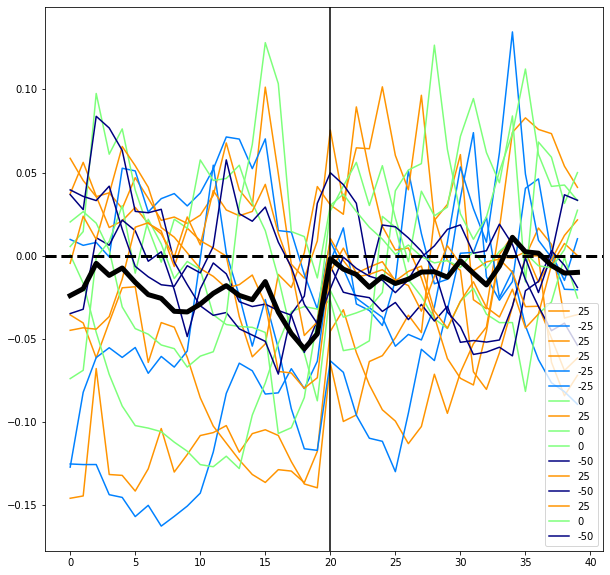

In [364]:
cmap = matplotlib.cm.get_cmap('jet')
colors = [0,.25,.5,.75,.9]

indicies = np.searchsorted(timestamps[:,20], theta_categories[50])
window_width = 20

plt.figure(figsize=(10,10))
traces = []
for i,idx in enumerate(indicies):
    color = colors[np.where(previous_theta[i] == thetas)[0][0]]
    trace = mean_neural[idx-window_width:idx+window_width]
    traces.append(trace)
    plt.plot(trace,color=cmap(color),label=previous_theta[i])
plt.plot(np.mean(np.asarray(traces),axis=0),color='k',lw=5)
plt.axvline(20,color='k')
plt.axhline(0,color='k',lw=3,linestyle='--')
plt.legend()

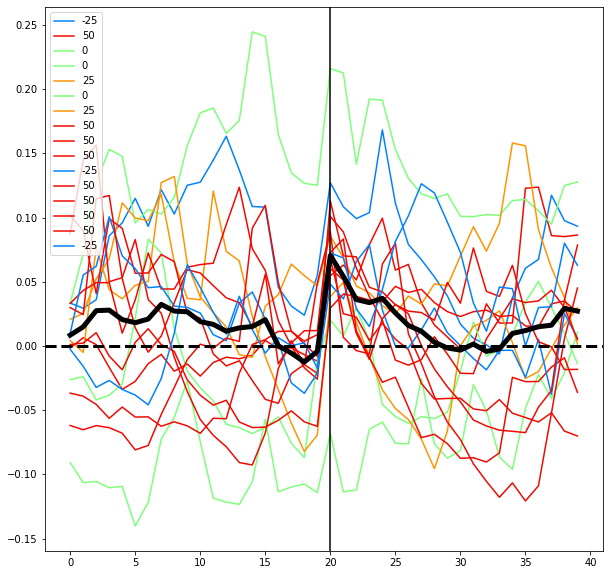

In [366]:
cmap = matplotlib.cm.get_cmap('jet')
colors = [0,.25,.5,.75,.9]

theta = -50
indicies = np.searchsorted(timestamps[:,20], theta_categories[theta])
window_width = 20

idx = np.where(start_thetas==theta)[0]
idx -= 1
previous_theta = start_thetas[idx]

plt.figure(figsize=(10,10))
traces = []
for i,idx in enumerate(indicies):
    color = colors[np.where(previous_theta[i] == thetas)[0][0]]
    trace = mean_neural[idx-window_width:idx+window_width]
    traces.append(trace)
    plt.plot(trace,color=cmap(color),label=previous_theta[i])
plt.plot(np.mean(np.asarray(traces),axis=0),color='k',lw=5)
plt.axvline(20,color='k')
plt.axhline(0,color='k',lw=3,linestyle='--')
plt.legend()

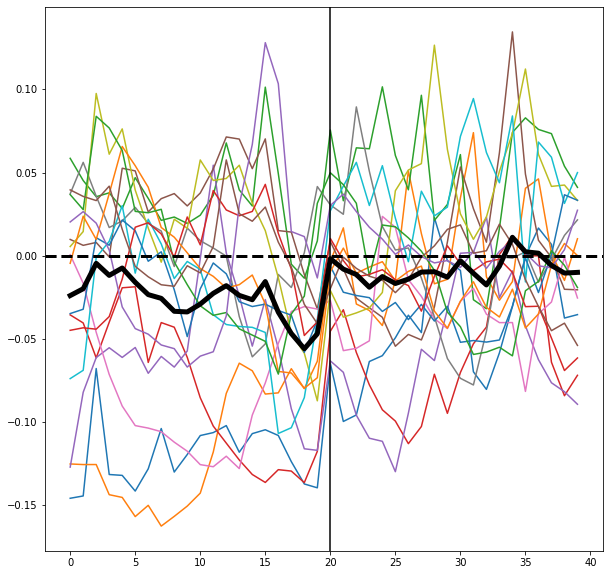

In [355]:
indicies = np.searchsorted(timestamps[:,20], theta_categories[50])
window_width = 20

plt.figure(figsize=(10,10))
traces = []
for idx in indicies:
    trace = mean_neural[idx-window_width:idx+window_width]
    traces.append(trace)
    plt.plot(trace)
plt.plot(np.mean(np.asarray(traces),axis=0),color='k',lw=5)
plt.axvline(20,color='k')
plt.axhline(0,color='k',lw=3,linestyle='--')

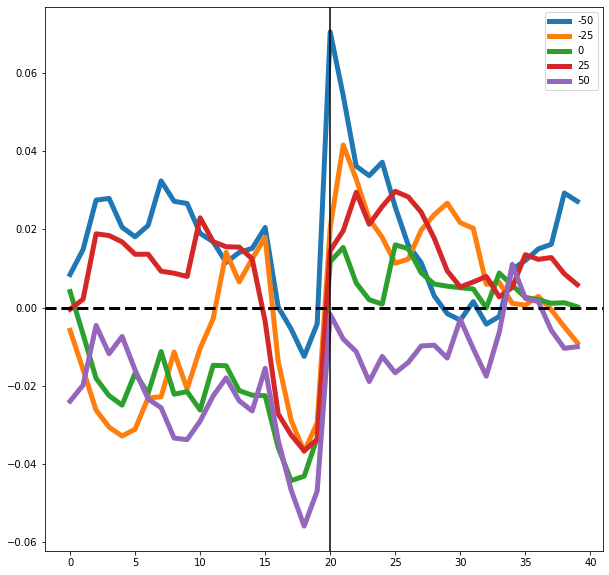

In [322]:
window_width = 20
plt.figure(figsize=(10,10))
for theta in thetas:
    indicies = np.searchsorted(timestamps[:,20], theta_categories[theta])
    traces = []
    for idx in indicies:
        trace = mean_neural[idx-window_width:idx+window_width]
        traces.append(trace)
        #plt.plot(trace)
    plt.plot(np.mean(np.asarray(traces),axis=0),lw=5,label=theta)
plt.axvline(20,color='k')
plt.axhline(0,color='k',lw=3,linestyle='--')
plt.legend()

In [327]:
len(trace)

40

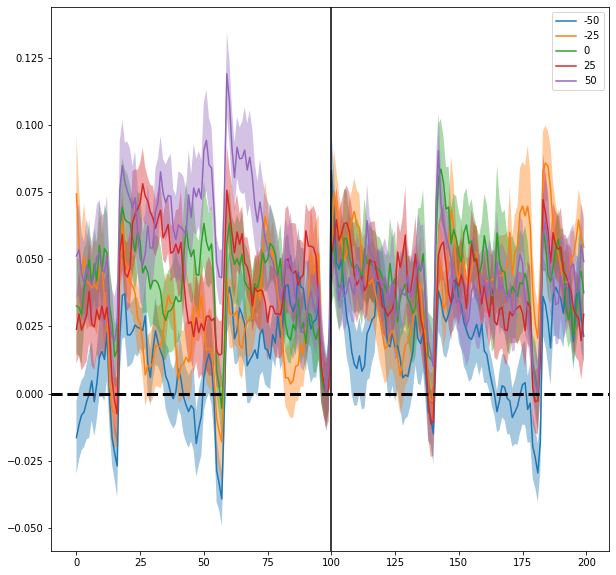

In [349]:
window_width = 100
xs = np.arange(0,window_width*2,1)
plt.figure(figsize=(10,10))
for theta in thetas:
    indicies = np.searchsorted(timestamps[:,20], theta_categories[theta])
    traces = []
    for idx in indicies:
        trace = mean_neural[idx-window_width:idx+window_width]
        if len(trace) != window_width*2:
            continue
        traces.append(trace)
        #plt.plot(trace)
    meantrace = np.mean(np.asarray(traces),axis=0)
    meantrace -= np.min(meantrace[80:100])
    sem = scipy.stats.sem(np.asarray(traces),axis=0)
    plt.plot(meantrace,label=theta)
    plt.fill_between(xs,meantrace-sem,meantrace+sem,alpha=.4)
    #plt.plot(meantrace,lw=2,label=theta)
plt.axvline(100,color='k')
plt.axhline(0,color='k',lw=3,linestyle='--')
plt.legend()

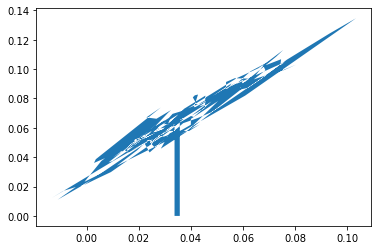

In [337]:
plt.fill_between(meantrace-sem,meantrace+sem)

In [339]:
len(meantrace), len(sem)

(200, 200)

In [340]:
meantrace-sem

array([ 0.03575167,  0.03635171,  0.03048825,  0.02542093,  0.03011843,
        0.0255332 ,  0.02457853,  0.02697191,  0.03125731,  0.03243552,
        0.02680967,  0.02293281,  0.02846114,  0.00867264,  0.00353462,
        0.00284652,  0.01060766,  0.0576361 ,  0.06767045,  0.06376837,
        0.05681284,  0.0535237 ,  0.05342707,  0.05558108,  0.04380233,
        0.03393221,  0.03208584,  0.03742007,  0.04722331,  0.04010386,
        0.04109256,  0.05177575,  0.05491221,  0.06910677,  0.06196787,
        0.05679202,  0.05989785,  0.05761853,  0.04623568,  0.04111503,
        0.04274803,  0.04151063,  0.04075476,  0.04241166,  0.05714402,
        0.0494028 ,  0.06012493,  0.05887868,  0.06224809,  0.05782888,
        0.07273858,  0.07545686,  0.06770214,  0.06862347,  0.05544643,
        0.03929765,  0.03343956,  0.03277734,  0.06085601,  0.10337744,
        0.0933056 ,  0.07681473,  0.06734723,  0.08034539,  0.07552852,
        0.0742593 ,  0.07461649,  0.0657701 ,  0.07040105,  0.06

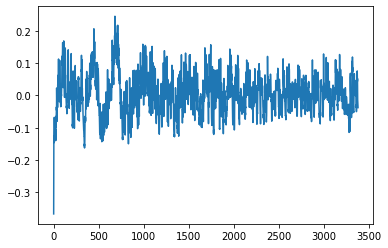

In [309]:
plt.plot(mean_neural)

(array([3., 0., 0., 3., 0., 0., 2., 0., 0., 8.]),
 array([-25. , -17.5, -10. ,  -2.5,   5. ,  12.5,  20. ,  27.5,  35. ,
         42.5,  50. ]),
 <BarContainer object of 10 artists>)

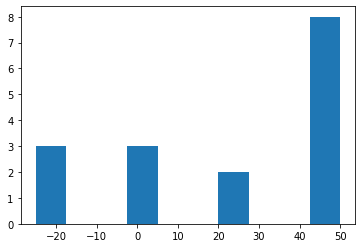

In [301]:
idx = np.where(start_thetas==-50)[0]
idx -= 1
plt.hist(start_thetas[idx])

(array([3., 0., 0., 3., 0., 0., 4., 0., 0., 6.]),
 array([-50. , -42.5, -35. , -27.5, -20. , -12.5,  -5. ,   2.5,  10. ,
         17.5,  25. ]),
 <BarContainer object of 10 artists>)

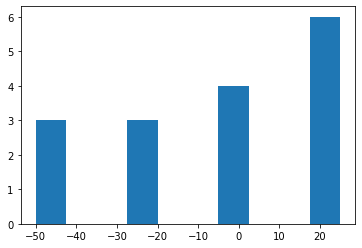

In [303]:
idx = np.where(start_thetas==50)[0]
idx -= 1
plt.hist(start_thetas[idx])

In [302]:
start_thetas[idx]

array([-25,  50,   0,   0,  25,   0,  25,  50,  50,  50, -25,  50,  50,
        50,  50, -25])

In [168]:
np.where(start_thetas==theta)[0]

array([ 0,  8, 11, 18, 20, 25, 32, 37, 41, 48, 50, 58, 60, 68, 72, 77])

In [166]:
start_thetas

array([ 50, -25, -50,   0,  25,  25,   0, -25,  50, -50,  25,  50,   0,
       -50, -25,   0, -50,  25,  50, -25,  50,   0,  25, -50, -25,  50,
         0, -50, -25,  25, -50,   0,  50,  25, -25, -25,  25,  50, -50,
         0,   0,  50, -50,  25, -25, -25,  25,   0,  50, -50,  50, -25,
       -50,  25,   0, -25,   0,  25,  50, -50,  50, -50, -25,  25,   0,
       -25,   0,  25,  50, -50, -25,   0,  50, -50,  25, -25, -50,  50,
        25,   0,  25])

In [165]:
thetas

array([-50, -25,   0,  25,  50])

In [164]:
theta_categories[-50]

array([  57304,  211468,  299567,  365623,  519791,  607887,  673967,
        850133,  938232, 1092355, 1158428, 1312591, 1356645, 1532861,
       1620944, 1687008])

In [154]:
stimulus_start_times

array([  13275,   35277,   57304,   79331,  101358,  123377,  145403,
        167423,  189449,  211468,  233495,  255513,  277565,  299567,
        321586,  343605,  365623,  387659,  409685,  431711,  453718,
        475733,  497785,  519791,  541814,  563833,  585868,  607887,
        629931,  651941,  673967,  696003,  718013,  740032,  762077,
        784086,  806096,  828115,  850133,  872169,  894187,  916206,
        938232,  960243,  982262, 1004306, 1026312, 1048326, 1070345,
       1092355, 1114390, 1136401, 1158428, 1180466, 1202474, 1224492,
       1246544, 1268554, 1290573, 1312591, 1334627, 1356645, 1378664,
       1400699, 1422710, 1444737, 1466772, 1488782, 1510839, 1532861,
       1554871, 1576915, 1598925, 1620944, 1642963, 1664998, 1687008,
       1709027, 1731071, 1753076, 1775091])

In [278]:
bin_start = -5000; bin_end = 5000; bin_size = 200
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [201]:
reformed_STA_brain.shape

(49, 54, 256, 128)

In [202]:
len(neural_bins)

55

In [217]:
theta_categories[50]

array([  13275,  189449,  255513,  409685,  453718,  563833,  718013,
        828115,  916206, 1070345, 1114390, 1290573, 1334627, 1510839,
       1598925, 1709027])

In [218]:
theta_categories[-50]

array([  57304,  211468,  299567,  365623,  519791,  607887,  673967,
        850133,  938232, 1092355, 1158428, 1312591, 1356645, 1532861,
       1620944, 1687008])

In [259]:
theta=50
event_times_list = theta_categories[-25]

t0 = time.time()
STA_brain = make_STA_brain(neural_signals = all_signals,
                                   neural_timestamps = timestamps,
                                   event_times_list = event_times_list,
                                   neural_bins = neural_bins)

In [255]:
event_times_list

array([  57304,  211468,  299567,  365623,  519791,  607887,  673967,
        850133,  938232, 1092355, 1158428, 1312591, 1356645, 1532861,
       1620944, 1687008])

In [253]:
event_times_list

array([  35277,  167423,  321586,  431711,  541814,  629931,  762077,
        784086,  982262, 1004306, 1136401, 1224492, 1378664, 1444737,
       1554871, 1664998])

In [251]:
def make_STA_brain(neural_signals, neural_timestamps, event_times_list, neural_bins):
    #### super voxel version
    
    STA_brain = []
    for z in [20,21]:#range(49):
        all_bin_indicies = []
        for stim_idx in range(len(event_times_list)):
            stim_time = event_times_list[stim_idx]
            stim_centered_bins = neural_bins + stim_time
            bin_indicies = np.digitize(neural_timestamps[:,z] , stim_centered_bins)
            all_bin_indicies.append(bin_indicies)
        all_bin_indicies = np.asarray(all_bin_indicies)

        avg_neural_across_bins = []
        for bin_num in np.arange(1,len(neural_bins)):
            
            this_bin_sample_times = list(np.where(all_bin_indicies==bin_num)[1])
            #print(neural_signals[z,:,this_bin_sample_times].shape)
            average_neural_in_bin = np.mean(neural_signals[z,:,this_bin_sample_times],axis=0)
            avg_neural_across_bins.append(average_neural_in_bin)
        avg_neural_across_bins = np.asarray(avg_neural_across_bins)
        STA_brain.append(avg_neural_across_bins)
    STA_brain = np.asarray(STA_brain)
    return STA_brain

In [231]:
all_signals.shape

(49, 2000, 3384)

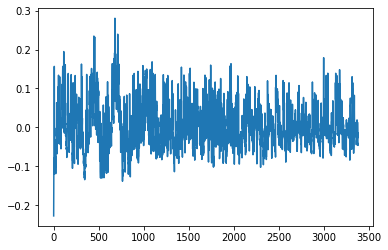

In [240]:
out = np.mean(all_signals,axis=1)
plt.plot(out[20,:])

In [220]:
STA_brain.shape

(49, 54, 2000)

In [279]:
all_explosions = {}
for theta in [50]:
    print(theta)
    event_times_list = theta_categories[theta]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_223', fixed=fixed, anat_to_mean_type='myr')
    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[theta] = explosions

50
STA 0.5477170944213867
Warps 19.51094698905945
Explosion 52.270665884017944


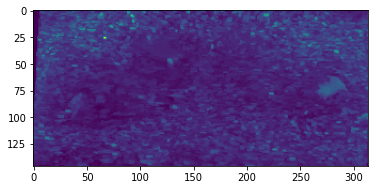

In [261]:
plt.imshow(np.max(warps[5][:,:,::-1],axis=-1).T)

In [207]:
for tp in range(len(neural_bins)-1):
    warps[tp].shape

In [183]:
neural_bins

array([-500, -400, -300, -200, -100,    0,  100,  200,  300,  400,  500,
        600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600,
       1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700,
       2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800,
       3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900])

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



IndexError: list index out of range

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

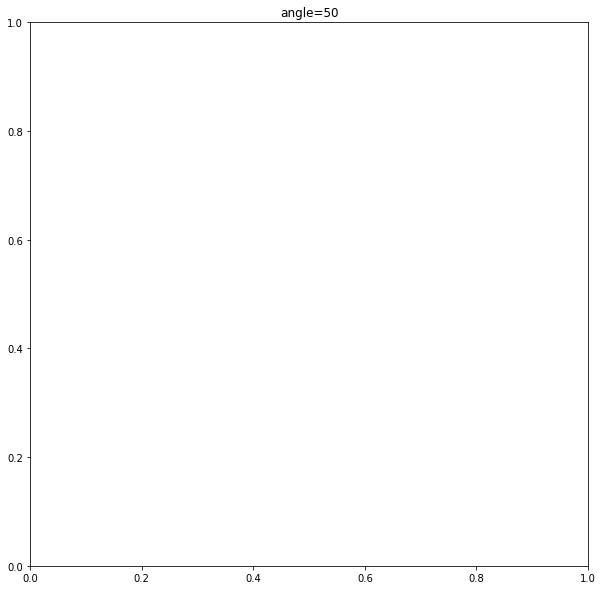

In [280]:
save_path = os.path.join(func_path,'figs','20220905d')
os.mkdir(save_path)

for tp in range(len(neural_bins)):
    plt.figure(figsize=(10,10))
    plt.title('angle=50')
    plt.imshow(all_explosions[50][tp][150:,:])
    plt.text(20,50,f'{neural_bins[tp]}ms',fontsize='20')
    save_file = os.path.join(save_path,str(tp).zfill(5))
    plt.savefig(save_file,dpi=200,bbox_inches='tight')
    plt.clf()

In [199]:
'4'.zfill(3)

'004'